### Оглавление

[1 Постановка задачи](#task_cell)

[2 Аналитика полученных данных](#first_analyze_cell)

[3 Подготовка данных](#prepare_cell)

[4 Выбор модели](#other_model_cell)

[5 Оценки модели](#score_cell)

## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# параметры отображения pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')

In [3]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [5]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#from xgboost import XGBRegressor # conda install -c conda-forge xgboost или # conda install -c anaconda py-xgboost
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score


In [6]:
# вспомогательная функция
def code_mean(data, cat_feature, real_feature):
    """возвращает значение нового признака на основе вещественного значения другого"""
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

<a id='task_cell'>==========================================================</a>

## Задача 1:
- Проведите аналитику полученных данных 
- Подготовьте данные для регрессионной модели 
- Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES 
- Оцените качество модели с помощью функции metric 

## Метрика для оценки Вашей модели

In [7]:
def metric(y_true, y_pred):    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

## Данные

In [8]:
df = pd.read_csv(r'.\data\data_regression_for_task.csv')

In [9]:
df.head(5)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.00,0.00
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.00,0.00
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.00,0.00
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.00,0.00
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.00,0.00


## Описание

- YEAR: год продажи 
- MONTH: месяц продажи 
- CONTRAGENT: поставщик товарной позиции 
- ARTICLE_CODE: код товарной позиции 
- ARTICLE_NAME: название товарной позиции 
- ARTICLE_GROUP: название группы товарных позиций 
- SALES: продажи товарной позиции в этот месяц и год (целевая переменная) 
- STORE_SALES: продажи всего магазина 


<a id='first_analyze_cell'>==========================================================</a>

# Аналитика полученных данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [11]:
df.describe(include=['int64','float64','object'])

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
count,128355.00,128355.00,128331,128355,128355,128354,128355.00,128355.00
unique,nan,nan,333,23556,23624,8,nan,nan
top,nan,nan,REPUBLIC NATIONAL DISTRIBUTING CO,95524,LA VIELLE FERME CDV RED - 750ML,WINE,nan,nan
freq,nan,nan,9847,10,19,79077,nan,nan
mean,2017.21,7.08,NaN,NaN,NaN,NaN,6563.04,22.62
std,0.40,3.65,NaN,NaN,NaN,NaN,28924.94,239.69
min,2017.00,1.00,NaN,NaN,NaN,NaN,-6490.00,-4996.00
25%,2017.00,5.00,NaN,NaN,NaN,NaN,0.00,0.00
50%,2017.00,8.00,NaN,NaN,NaN,NaN,330.00,1.00
75%,2017.00,10.00,NaN,NaN,NaN,NaN,3250.00,4.00


#### <font color='red'> В исходном датасете есть выбросы и шумы. Есть пропуски в данных. Далее нужно будет посмотреть распределение по каждому признаку</font>

### Ошибки в данных, которые виды из общего описания
- 1 Есть отрицательные цены в продажах и магазинах
- 2 Есть дубли в названиях ARTICLE_NAME для одинаковых ARTICLE_CODE

In [12]:
# 5 самых продаваемых товаров. В последнем периоде
df[df['YEAR'] == 2018][df['MONTH'] == 2].sort_values(by=['SALES']).tail(5)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
128210,2018,2,CROWN IMPORTS,96741,CORONA EXTRA 4/6 NR - 12OZ,BEER,434480.00,4305.46
122167,2018,2,SAZERAC CO,35840,BOWMAN'S VODKA - 1.75L,LIQUOR,583890.00,4.00
117267,2018,2,HEINEKEN USA,23886,HEINEKEN LOOSE NR - 12OZ,BEER,615000.00,6111.88
117026,2018,2,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,973000.00,9518.88
124541,2018,2,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,983020.00,18.00


In [13]:
df.corr()

,YEAR,MONTH,SALES,STORE_SALES
YEAR,1.00,-0.78,-0.01,-0.01
MONTH,-0.78,1.00,0.03,0.01
SALES,-0.01,0.03,1.00,0.46
STORE_SALES,-0.01,0.01,0.46,1.00


### Продажи товаров коррелируют с общей продажей магазина. В реальности мы не будем знать продажи магазина в следующем периоде. Поэтому данную переменную использовать не сможем. <font color='green'>Но мы будем знать продажи магазина в предыдущих периодах.</font>

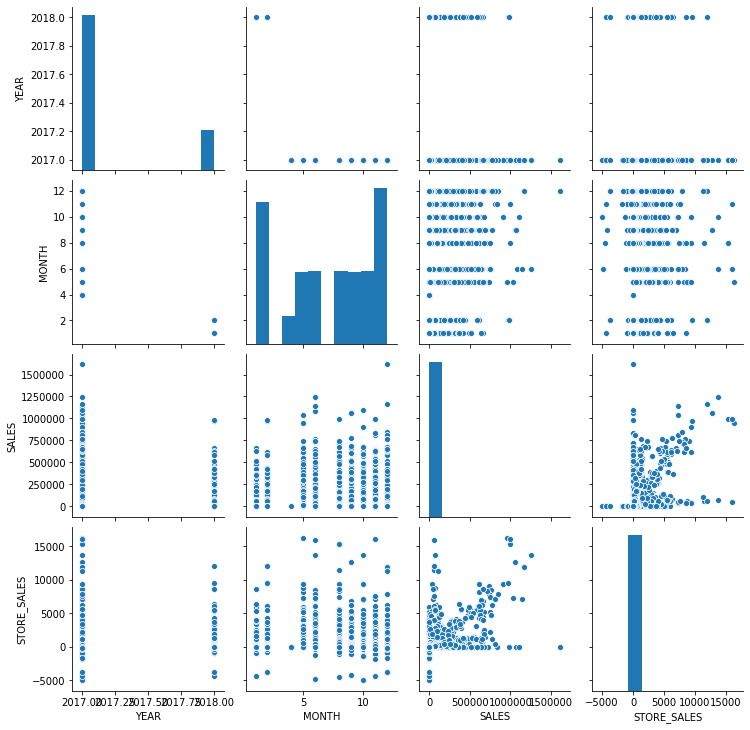

In [14]:
# построим парные диаграммы зависимости вещественных признаков
cols = df.select_dtypes(exclude=['object']).columns
sns.pairplot(df[cols])

### Выводы из парных графиков
- При нулевых продажах SALES, магазин может продавать другие позиции
- Есть сезонность продаж, по месяцам
- нет данных по июню 7-ому месяцу, в 2017 


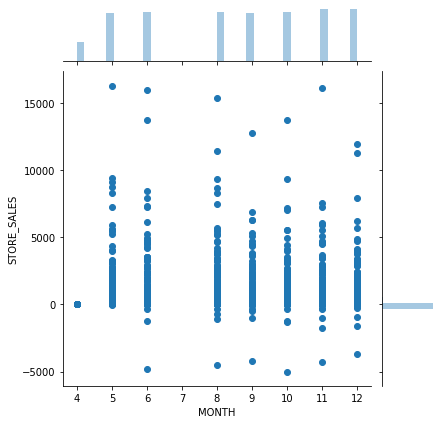

In [15]:
sns.jointplot(data=df[df['YEAR'] == 2017], x="MONTH", y="STORE_SALES")

Text(0.5, 1.0, 'Распределение продаж магазинов')

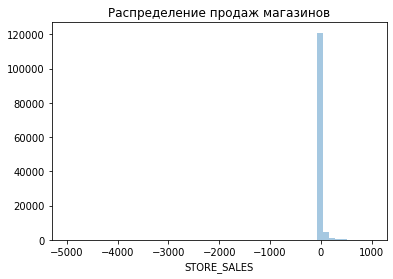

In [16]:
sns.distplot(df[df['STORE_SALES']< 1000]['STORE_SALES'], kde=False).set_title("Распределение продаж магазинов")

### зависимость категориальных признаков 

Text(0.5, 1.0, 'Зависимость продаж от группы')

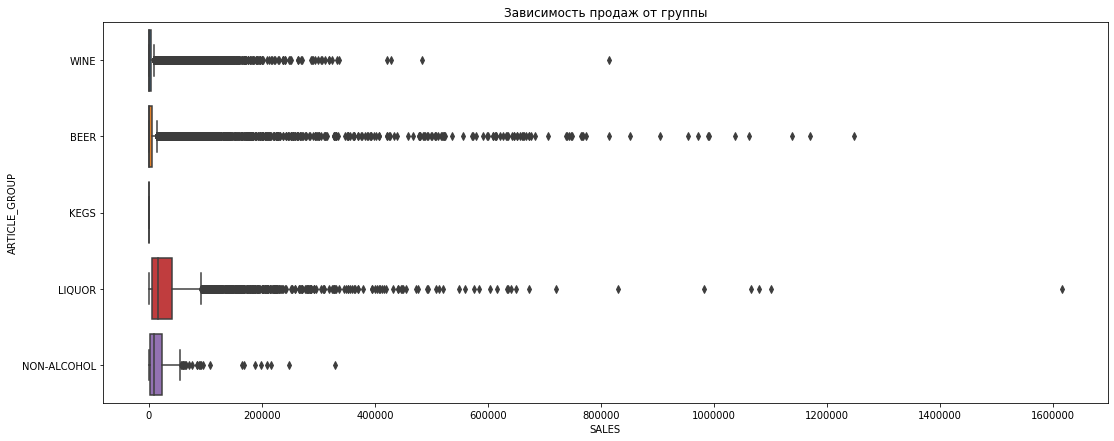

In [67]:
plt.figure(figsize(18,7))
sns.boxplot(y='ARTICLE_GROUP', x='SALES', data=df, orient='h').set_title("Зависимость продаж от группы")

#### Из распрделения видно, что в основном покупают пиво. При этом очень большой разброс между разными марками.

<a id='prepare_cell'>==========================================================</a>

# Подготовка данных

In [18]:
# Вопрос к заказчику - Почему отрицательные цены? Почему при наличие продаж по товару, в целом по магазину стоит 0 ? Похоже на ошибку в данных.
df = df[df['SALES'] >= 0]
print('Убрали отрицательные продажи', df.shape[0])

df = df[df['STORE_SALES'] > 0]
print('Убрали пустые продажи в магазинах', df.shape[0])

df.dropna(inplace=True)
print('Убрали не заполненные данные', df.shape[0])

Убрали отрицательные продажи 128300
Убрали пустые продажи в магазинах 78397
Убрали не заполненные данные 78396


In [19]:
# дополним данными по продажам за последние 3 месяца
df_before = df[df['MONTH'] == 5]
df_before['MONTH'] = 4
df = df.append(df_before)
df_before = df[df['MONTH'] == 5]
df_before['MONTH'] = 3
df = df.append(df_before)
df_before = df[df['MONTH'] == 5]
df_before['MONTH'] = 2
df = df.append(df_before)

In [20]:
# сортируем по товару и периоду
df.sort_values(by=['ARTICLE_CODE','YEAR','MONTH'], inplace=True)
df['MONTH'] = np.where(df['YEAR'] == 2018, df['MONTH'] + 12 , df['MONTH'])
# временный сдвиг, чтобы соблюсти последовательность
df['MONTH'] = np.where(df['MONTH'] < 8, df['MONTH'] + 1 , df['MONTH'])

In [21]:
# вспомогательная функция по расчёту продаж в предыдущих периодах
def calc_prev(df_calc, COLUMNS_NAME,  n_period = 1,):
    df_calc['PREV_' + COLUMNS_NAME + '_' + str(n_period) ] = np.where(((df_calc['ARTICLE_CODE'] == df_calc['ARTICLE_CODE'].shift(n_period))
                             & ((df_calc['MONTH'] == (df_calc['MONTH'].shift(n_period) + n_period ))   )
                            ), df_calc[COLUMNS_NAME].shift(n_period), 0)
    return df_calc
df = calc_prev(df, 'SALES', 1)
df = calc_prev(df, 'SALES', 2)
df = calc_prev(df, 'SALES', 3)
df = calc_prev(df, 'STORE_SALES', 1)
df = calc_prev(df, 'STORE_SALES', 2)
df = calc_prev(df, 'STORE_SALES', 3)

In [22]:
# обратный сдвиг
df['MONTH'] = np.where(df['MONTH'] < 8, df['MONTH'] - 1 , df['MONTH'])
df['MONTH'] = np.where(df['YEAR'] == 2018, df['MONTH'] - 12 , df['MONTH'])

In [23]:
# убираем добавленный месяцы
df = df[~((df['YEAR'] == 2017) & (df['MONTH'].isin([2,3,4])))]
#.groupby(['YEAR','MONTH'])[['SALES','STORE_SALES','PREV_SALES_1','PREV_SALES_2','PREV_SALES_3','PREV_STORE_SALES_1','PREV_STORE_SALES_2','PREV_STORE_SALES_3']].sum()

In [24]:
df.groupby(['YEAR','MONTH'])[['SALES','STORE_SALES','PREV_SALES_1','PREV_SALES_2','PREV_SALES_3','PREV_STORE_SALES_1','PREV_STORE_SALES_2','PREV_STORE_SALES_3']].sum()

SALES  STORE_SALES  PREV_SALES_1  PREV_SALES_2  \
YEAR MONTH                                                         
2017 5      77621100.00    367468.39   77621100.00   77621100.00   
     6      78729830.00    385859.83   72755900.00   72755900.00   
     8      70696990.00    388848.98   74453930.00   70427280.00   
     9      73831850.00    311549.28   67032420.00   71822540.00   
     10     72740100.00    311674.41   70045740.00   65118580.00   
     11     79717560.00    347056.66   68136490.00   67503150.00   
     12    101861530.00    313711.55   74367530.00   65585470.00   
2018 1      60685250.00    260233.91   95900340.00   71142650.00   
     2      62748870.00    269917.60   57933090.00   93005670.00   

            PREV_SALES_3  PREV_STORE_SALES_1  PREV_STORE_SALES_2  \
YEAR MONTH                                                         
2017 5       77621100.00           367468.39           367468.39   
     6       72755900.00           361398.37           361398.37   
     8       70427280.00           376871.27           355942.91   
     9       68573010.00           382491.70           371725.55   
     10      70087140.00           305935.86           377932.31   
     11      64090460.00           302740.09           297815.23   
     12      65456860.00           339288.99           298871.44   
2018 1       64128640.00           305270.00           329973.73   
     2       69743190.00           255176.92           301294.92   

            PREV_STORE_SALES_3  
YEAR MONTH                      
2017 5               367468.39  
     6               361398.37  
     8               355942.91  
     9               351394.31  
     10              368363.79  
     11              371938.55  
     12              295030.15  
2018 1               294924.52  
     2               326286.39

In [25]:
#df[df['STORE_SALES'] == 4].mean()

In [26]:
df.head(3)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,PREV_SALES_1,PREV_SALES_2,PREV_SALES_3,PREV_STORE_SALES_1,PREV_STORE_SALES_2,PREV_STORE_SALES_3
5202,2017,5,CONSTANTINE WINES INC,100003,LA CETTO ZINFANDEL - 750ML,WINE,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
5203,2017,5,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
59261,2017,10,CONSTANTINE WINES INC,100008,AMITY VINEYARDS P/NOIR 2013 - 750ML,WINE,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [27]:
# Переводим категориальные признаки ARTICLE_GROUP Группа товаров и CONTRAGENT контрагент в бинарные признаки. 1 да, 0 нет.
onehot_df = pd.get_dummies(df[['ARTICLE_GROUP']])
df = pd.concat([df,onehot_df], axis = 1)

In [28]:
df.head(2)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,PREV_SALES_1,PREV_SALES_2,PREV_SALES_3,PREV_STORE_SALES_1,PREV_STORE_SALES_2,PREV_STORE_SALES_3,ARTICLE_GROUP_BEER,ARTICLE_GROUP_KEGS,ARTICLE_GROUP_LIQUOR,ARTICLE_GROUP_NON-ALCOHOL,ARTICLE_GROUP_WINE
5202,2017,5,CONSTANTINE WINES INC,100003,LA CETTO ZINFANDEL - 750ML,WINE,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0,0,0,0,1
5203,2017,5,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0,0,0,0,1


In [29]:
# Переводим признак кода товара (или наименование товара в вещественный признак, привязанный к средней цене товара)
# Если заполнять признаковую матрицу для каждого товара, то получается слишком большая матрица. Возможное решение - закодировать средней ценой товара. Новый признак будет упорядочивать товары по дороговизне 
df['ARTICLE_CODE_digitized'] = code_mean(df, 'ARTICLE_CODE' , 'SALES')
df['CONTRAGENT_digitized'] = code_mean(df, 'CONTRAGENT', 'SALES')

In [30]:
#df.drop(columns=['PREV_SALES'],inplace = True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78396 entries, 5202 to 45870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR                       78396 non-null  int64  
 1   MONTH                      78396 non-null  int64  
 2   CONTRAGENT                 78396 non-null  object 
 3   ARTICLE_CODE               78396 non-null  object 
 4   ARTICLE_NAME               78396 non-null  object 
 5   ARTICLE_GROUP              78396 non-null  object 
 6   SALES                      78396 non-null  float64
 7   STORE_SALES                78396 non-null  float64
 8   PREV_SALES_1               78396 non-null  float64
 9   PREV_SALES_2               78396 non-null  float64
 10  PREV_SALES_3               78396 non-null  float64
 11  PREV_STORE_SALES_1         78396 non-null  float64
 12  PREV_STORE_SALES_2         78396 non-null  float64
 13  PREV_STORE_SALES_3         78396 non-null  

In [32]:
# Берём все колонки, кроме object (текстовых категориальных признаков)
df_sales = df.select_dtypes(exclude=['object'])
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78396 entries, 5202 to 45870
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR                       78396 non-null  int64  
 1   MONTH                      78396 non-null  int64  
 2   SALES                      78396 non-null  float64
 3   STORE_SALES                78396 non-null  float64
 4   PREV_SALES_1               78396 non-null  float64
 5   PREV_SALES_2               78396 non-null  float64
 6   PREV_SALES_3               78396 non-null  float64
 7   PREV_STORE_SALES_1         78396 non-null  float64
 8   PREV_STORE_SALES_2         78396 non-null  float64
 9   PREV_STORE_SALES_3         78396 non-null  float64
 10  ARTICLE_GROUP_BEER         78396 non-null  uint8  
 11  ARTICLE_GROUP_KEGS         78396 non-null  uint8  
 12  ARTICLE_GROUP_LIQUOR       78396 non-null  uint8  
 13  ARTICLE_GROUP_NON-ALCOHOL  78396 non-null  

In [33]:
#df_sales['PERIOD_SORT'] = (df_sales['YEAR'].sub(2016).mul(100) + df_sales['MONTH']) 
df_sales.head()

,YEAR,MONTH,SALES,STORE_SALES,PREV_SALES_1,PREV_SALES_2,PREV_SALES_3,PREV_STORE_SALES_1,PREV_STORE_SALES_2,PREV_STORE_SALES_3,ARTICLE_GROUP_BEER,ARTICLE_GROUP_KEGS,ARTICLE_GROUP_LIQUOR,ARTICLE_GROUP_NON-ALCOHOL,ARTICLE_GROUP_WINE,ARTICLE_CODE_digitized,CONTRAGENT_digitized
5202,2017,5,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0,0,0,0,1,0.00,1207.36
5203,2017,5,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0,0,0,0,1,0.00,1207.36
59261,2017,10,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0.00,1207.36
72880,2017,11,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0.00,1624.62
87412,2017,12,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,1,0.00,1624.62


In [34]:
#df_sales.groupby(['YEAR','MONTH'])[['SALES','STORE_SALES']].sum().reset_index()

<a id='other_model_cell'>==========================================================</a>

# Выбор модели

In [35]:
def train_test_split_manual(X, target, columns_sort, values_sort):
    X_test = X[X[columns_sort[0]].isin(values_sort[0])][X[columns_sort[1]].isin(values_sort[1])]
    y_test = X_test[[target]] 
    X_test.drop(columns=[target], inplace=True)
    
    X_train = X[~X[columns_sort[1]].isin(values_sort[1])]
    y_train = X_train[[target]]
    X_train.drop(columns=[target], inplace=True)
    return  X_train, X_test, y_train, y_test

In [36]:
# Разделение выборки на train и test с сортировкой по дате
# 'STORE_SALES',
X_train, X_test, y_train, y_test = train_test_split_manual(df_sales.drop(columns=['STORE_SALES'], axis=1), 'SALES', ['YEAR','MONTH'], [[2018],[2]])

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70064 entries, 5202 to 45870
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR                       70064 non-null  int64  
 1   MONTH                      70064 non-null  int64  
 2   PREV_SALES_1               70064 non-null  float64
 3   PREV_SALES_2               70064 non-null  float64
 4   PREV_SALES_3               70064 non-null  float64
 5   PREV_STORE_SALES_1         70064 non-null  float64
 6   PREV_STORE_SALES_2         70064 non-null  float64
 7   PREV_STORE_SALES_3         70064 non-null  float64
 8   ARTICLE_GROUP_BEER         70064 non-null  uint8  
 9   ARTICLE_GROUP_KEGS         70064 non-null  uint8  
 10  ARTICLE_GROUP_LIQUOR       70064 non-null  uint8  
 11  ARTICLE_GROUP_NON-ALCOHOL  70064 non-null  uint8  
 12  ARTICLE_GROUP_WINE         70064 non-null  uint8  
 13  ARTICLE_CODE_digitized     70064 non-null  

In [38]:
X_train.describe(include=['int64','float64','object'])

,YEAR,MONTH,PREV_SALES_1,PREV_SALES_2,PREV_SALES_3,PREV_STORE_SALES_1,PREV_STORE_SALES_2,PREV_STORE_SALES_3,ARTICLE_CODE_digitized,CONTRAGENT_digitized
count,70064.00,70064.00,70064.00,70064.00,70064.00,70064.00,70064.00,70064.00,70064.00,70064.00
mean,2017.12,7.83,8568.07,8020.90,7894.79,39.13,39.41,39.48,8627.55,8609.02
std,0.32,3.36,37061.56,35356.49,35482.74,322.45,330.15,335.46,34303.54,14871.49
min,2017.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2017.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,642.65
50%,2017.00,9.00,0.00,0.00,0.00,2.00,2.00,2.00,82.00,1624.62
75%,2017.00,11.00,4050.00,3320.00,2820.00,9.00,9.00,8.00,5222.22,16952.28
max,2018.00,12.00,1616600.00,1249000.00,1249000.00,16271.75,16271.75,16271.75,995666.67,403314.84


In [39]:
X_test.groupby(['YEAR','MONTH'])['ARTICLE_GROUP_BEER'].count()

YEAR  MONTH
2018  2        8332
Name: ARTICLE_GROUP_BEER, dtype: int64

In [40]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8332 entries, 115256 to 128352
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SALES   8332 non-null   float64
dtypes: float64(1)
memory usage: 130.2 KB


In [41]:
# предсказание продаж линейной регрессией
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
np.sqrt(mean_squared_error(lm.predict(X_train), y_train))

9629.735678421777

In [43]:
lm.predict(X_train).mean()

8790.309003197131

In [44]:
y_train.mean()

SALES   8790.31
dtype: float64

In [45]:
np.sqrt(mean_squared_error(lm.predict(X_test), y_test))

11888.888874824033

In [46]:
lm.predict(X_test).mean()

8343.392803096342

In [47]:
y_test.mean()

SALES   7531.07
dtype: float64

## Истинные продажи и их предсказания линейной моделью:

Text(0, 0.5, 'Estimated sales')

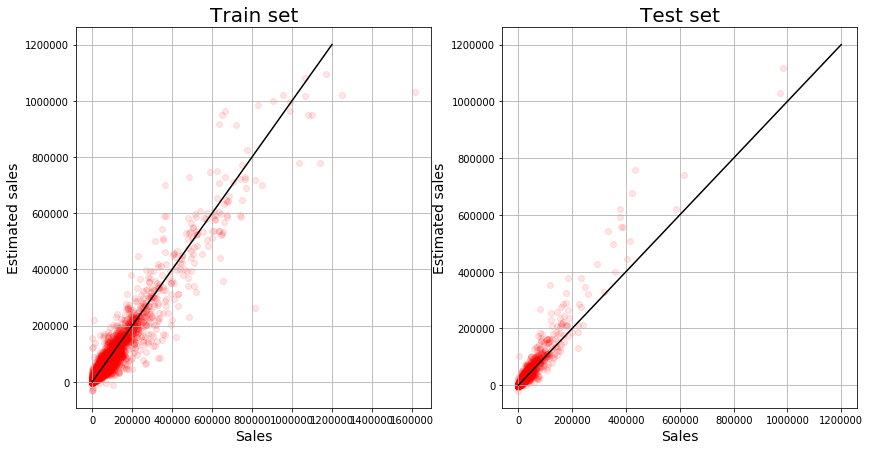

In [48]:
plt.figure(figsize(14,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
#pyplot.xlim(2.5,9.5)
#pyplot.ylim(2.5,9.5)
plot(range(1200000), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Sales', fontsize=14)
pyplot.ylabel('Estimated sales', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
#pyplot.xlim(2.5,9.5)
#pyplot.ylim(2.5,9.5)
plot(range(1200000), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Sales', fontsize=14)
pyplot.ylabel('Estimated sales', fontsize=14)

In [49]:
# Список моделей
pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("kn_classifier",KNeighborsRegressor())])


pipeline_gb=Pipeline([("scalar5",StandardScaler()),
                     ("gb_classifier",GradientBoostingRegressor())])


pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_gb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors",4: "GradientBoosting"}

# Обучаем каждую модель
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [50]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_mean_squared_error", cv=2)
    cv_results_rms.append(cv_score)
    print("%s:\t %s " % (pipe_dict[i], '{0:,}'.format(cv_score.mean()).replace(',', ' ')))

LinearRegression:	 -101 779 739.9715632 
DecisionTree:	 -163 482 598.5974728 
RandomForest:	 -93 809 075.05410138 
KNeighbors:	 -156 292 291.69290936 
GradientBoosting:	 -90 162 744.99018228 


#### <font color='green'> Модель Гадиентного бустинга показала лучшие результаты. Для прогноза будем использовать её.</font>

In [51]:
pred = pipeline_gb.predict(X_test)

In [52]:
# Прогноз по 5-ти самых продаваемым товаров
df_result = X_test
df_result['SALES'] = None
df_result = df_result.assign(SALES=pred)
#pd.concat([X_test,pd.DataFrame(data=pred, columns=['SALES'])], axis = 0).head(5)
df_result.sort_values(by=['SALES']).tail(5)

,YEAR,MONTH,PREV_SALES_1,PREV_SALES_2,PREV_SALES_3,PREV_STORE_SALES_1,PREV_STORE_SALES_2,PREV_STORE_SALES_3,ARTICLE_GROUP_BEER,ARTICLE_GROUP_KEGS,ARTICLE_GROUP_LIQUOR,ARTICLE_GROUP_NON-ALCOHOL,ARTICLE_GROUP_WINE,ARTICLE_CODE_digitized,CONTRAGENT_digitized,SALES
122167,2018,2,514130.00,673400.00,636350.00,6.00,8.00,2.00,0,0,1,0,0,582275.56,52591.14,493220.08
128210,2018,2,362770.00,765850.00,621790.00,3942.75,4701.79,5568.96,1,0,0,0,0,719292.22,69191.27,502003.37
117267,2018,2,485000.00,851000.00,814000.00,5888.79,7909.79,7220.00,1,0,0,0,0,697000.00,45763.68,507941.66
124541,2018,2,634760.00,1616600.00,830900.00,17.00,15.00,22.00,0,0,1,0,0,964950.00,403314.84,724975.50
117026,2018,2,665000.00,1170000.00,992000.00,8644.75,11932.79,16079.12,1,0,0,0,0,995666.67,69191.27,758181.01


In [63]:
# сравнение с истинными значениями
df.loc[[122167,128210,117267,124541,117026]][['ARTICLE_NAME','ARTICLE_GROUP','SALES']]

,ARTICLE_NAME,ARTICLE_GROUP,SALES
122167,BOWMAN'S VODKA - 1.75L,LIQUOR,583890.00
128210,CORONA EXTRA 4/6 NR - 12OZ,BEER,434480.00
117267,HEINEKEN LOOSE NR - 12OZ,BEER,615000.00
124541,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,983020.00
117026,CORONA EXTRA LOOSE NR - 12OZ,BEER,973000.00


<a id='score_cell'>==========================================================</a>

# Оценки модели

In [54]:
print("Коэффициент детерминации R^2:",metrics.r2_score(y_test, pred))
print("Скорректированный R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("Средняя абсолютная ошибка MAE:",metrics.mean_absolute_error(y_test, pred))
print("Средняя квадратическая ошибка MSE:",metrics.mean_squared_error(y_test, pred))
print("Корень RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
#
print("\n Предложенная функция оценки metric:",metric(y_test['SALES'].to_numpy(), pred) )

Коэффициент детерминации R^2: 0.9231909196622555
Скорректированный R^2: 0.9230431210711065
Средняя абсолютная ошибка MAE: 2184.0093161257564
Средняя квадратическая ошибка MSE: 68774916.59070395
Корень RMSE: 8293.064366728619

 Предложенная функция оценки metric: 28.11648750299452


Text(0, 0.5, 'Estimated sales')

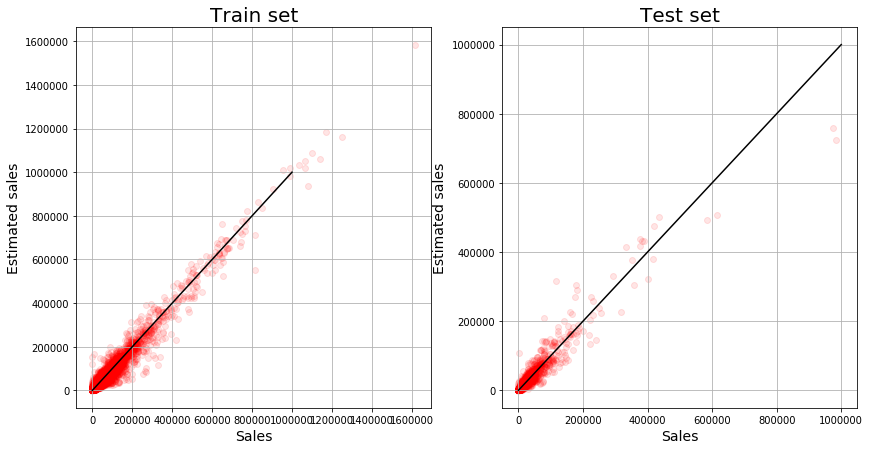

In [65]:
plt.figure(figsize(14,7))
plt.subplot(121)
pyplot.scatter(y_train, pipeline_gb.predict(X_train), color="red", alpha=0.1)
#pyplot.xlim(2.5,9.5)
#pyplot.ylim(2.5,9.5)
plot(range(1000000), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Sales', fontsize=14)
pyplot.ylabel('Estimated sales', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, pred, color="red", alpha=0.1)
#pyplot.xlim(2.5,9.5)
#pyplot.ylim(2.5,9.5)
plot(range(1000000), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Sales', fontsize=14)
pyplot.ylabel('Estimated sales', fontsize=14)